<a href="https://colab.research.google.com/github/chanwoo522/Hackathon/blob/main/ResNet_CNN_Vectorize_v0_02(toyou2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import PIL

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import re

import pandas as pd
import io
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 10 10:58:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])
  ))

Saving normalized_index.csv to normalized_index.csv
User uploaded file "normalized_index.csv" with length 1257 bytes


In [6]:
index = pd.read_csv(io.StringIO(uploaded['normalized_index.csv'].decode('utf-8')), header=None)
index = index.mean(axis=1)

## 구글 드라이브 마운트

In [7]:
# load image files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 작업 폴더 설정

In [8]:
## directory 설정
cur_dir = os.path.abspath('/content/drive/Othercomputers/내 컴퓨터/Desktop')
image_dir = os.path.join(cur_dir, 'mwir_resized_45_by_folder')
valid_dir = os.path.join(cur_dir, 'mwir_resized_45_by_folder')
classes = os.listdir(image_dir)
print(classes)

['04', '03', '06', '01', '05', '02', '11', '07', '08', '09', '12', '10', '18', '15', '16', '14', '17', '13', '19', '20', '22', '24', '23', '21', '29', '30', '27', '28', '25', '26', '35', '31', '36', '34', '33', '32', '37', '39', '38', '41', '42', '40', '44', '48', '46', '43', '47', '45', '49']


In [9]:
valid_data = datasets.ImageFolder(root = image_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in valid_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(valid_data)
stds /= len(valid_data)

pretrained_means = means
pretrained_stds = stds
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.2693, 0.2693, 0.2693])
Calculated stds: tensor([0.2081, 0.2081, 0.2081])


## 데이터 정규화 및 로드

In [10]:
# Hyperparameter
## Dataload
BATCH_SIZE = 2
pretrained_means = pretrained_means
pretrained_stds = pretrained_stds

image_data length : 49
image RGB Channel size, W, H : torch.Size([3, 260, 1140])
image_iterator length : 25


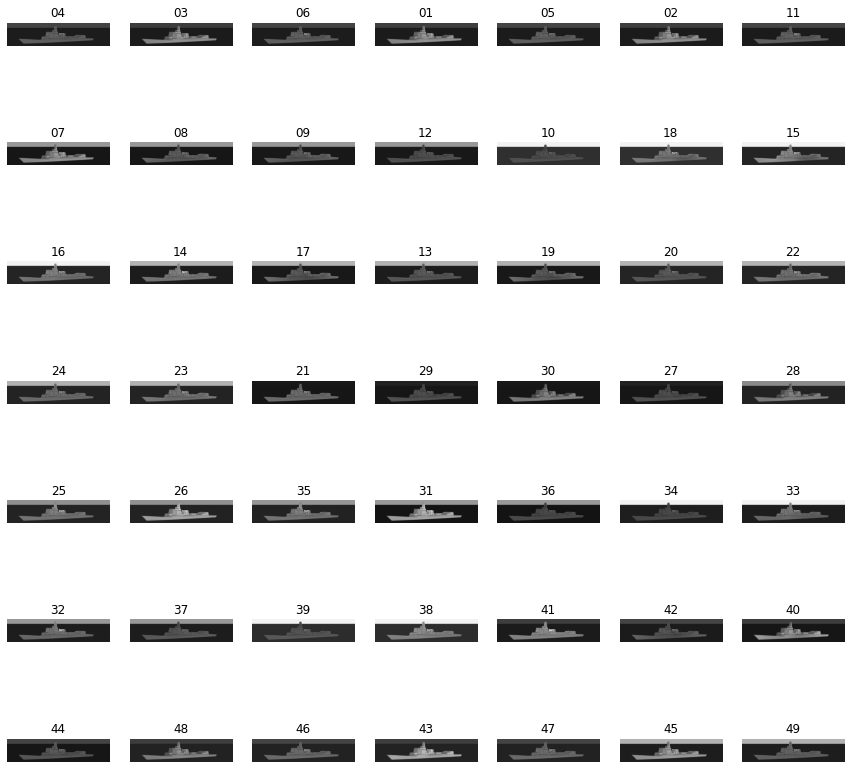

In [11]:
# Data load and transform
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(pretrained_means,
                                                     pretrained_stds)
])


image_data = datasets.ImageFolder(root=image_dir, transform=transform)
image_iterator = data.DataLoader(dataset = image_data, batch_size = BATCH_SIZE, shuffle=True)

valid_data = datasets.ImageFolder(root=valid_dir, transform=transform)
valid_iterator = data.DataLoader(dataset = valid_data, batch_size = BATCH_SIZE)

# Dataset check
print('image_data length :', len(image_data))
print('image RGB Channel size, W, H :', image_data[0][0].size())
print('image_iterator length :', len(image_iterator))

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (15, 15))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        if normalize:
            image = normalize_image(image)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

N_IMAGES = 49
images, labels = zip(*[(image, label) for image, label in [image_data[i] for i in range(N_IMAGES)]])
plot_images(images, labels, classes)

In [12]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label
image_data.classes = [format_label(c) for c in image_data.classes]

In [13]:
def scalar_product(mat, mulNum):
    for i in range (len(mat)):
        for j in range(len(mat[i])):
            mat[i][j] = mulNum * mat[i][j]
    return mat

In [21]:
label = list(range(49))

In [22]:
class ResNet(nn.Module):
  global target_tensor, predict_tensor
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        q = self.image_save(x)
        q = target_tensor        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        for j in label:
          for i in index:
            if i == j:
              x = scalar_product(x, i)
            else:
              pass

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h, q

    def image_save(self, x):
        q = x
        return q


class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)
        
        return x

IndentationError: ignored

In [23]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

resnet18_config = ResNetConfig(block = BasicBlock,n_blocks = [2,2,2,2], channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock, n_blocks = [3,4,6,3], channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
        predict_tensor = x
    
        return x

resnet50_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])
resnet101_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 23, 3], channels = [64, 128, 256, 512])
resnet152_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 8, 36, 3], channels = [64, 128, 256, 512])

class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [24]:
resnet50_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])
resnet101_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 23, 3], channels = [64, 128, 256, 512])
resnet152_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 8, 36, 3], channels = [64, 128, 256, 512])

class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)
        

class CIFARBasicBlock(nn.Module):
        
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], 
                                           [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                                
        x += i
        x = self.relu(x)
        
        return x

cifar_resnet20_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [3, 3, 3], channels = [16, 32, 64])
cifar_resnet32_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [5, 5, 5], channels = [16, 32, 64])
cifar_resnet44_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [7, 7, 7], channels = [16, 32, 64])
cifar_resnet56_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [9, 9, 9], channels = [16, 32, 64])
cifar_resnet110_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [18, 18, 18], channels = [16, 32, 64])
cifar_resnet1202_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [20, 20, 20], channels = [16, 32, 64])

In [25]:
pretrained_model = models.resnet101(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(image_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
model = ResNet(resnet101_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 42,600,561 trainable parameters


In [28]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.MSELoss(target_tensor, predict_tensor)

model = model.to(device)
criterion = criterion.to(device)

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _, q = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

NameError: ignored

In [29]:
torch.autograd.set_detect_anomaly(True)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(image_iterator, END_LR, NUM_ITER)

def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()
    
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 49])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

EPOCHS = 1000
STEPS_PER_EPOCH = len(image_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = MAX_LRS, total_steps = TOTAL_STEPS)

def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred, _, q = model(x)
        loss = criterion(y_pred, y)
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5, q

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _, q = model(x)
            loss = criterion(y_pred, y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5, q

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc_1, train_acc_5, train_image = train(model, image_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5, valid_image = evaluate(model, valid_iterator, criterion, device)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

    train_image = train_image[0, :, :, :]
    valid_image = valid_image[0, :, :, :]
    print(train_image.shape)
    print(valid_image.shape)
    print(train_image)
    print(valid_image)
    train_image = train_image.permute(1,2,0).cpu().numpy()
    valid_image = valid_image.permute(1,2,0).cpu().numpy()
    plt.imshow(train_image)
    plt.show()
    plt.imshow(valid_image)
    plt.show()